Overview

Using a pretrained model to segment Here is an example kernel where we use a pretrained VGG16 model as the encoder portion of a U-Net and thus can benefit from the features already created in the model and only focus on learning the specific decoding features. The strategy was used with LinkNet by one of the top placers in the competition. I wanted to see how well it worked in particular comparing it to standard or non-pretrained approaches, the code is setup now for VGG16 but can be easily adapted to other problems

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/kaggle/RSNA/content

/content/gdrive/My Drive/kaggle/RSNA/content


In [3]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 image_bbox_full.csv		        stage_2_train_images
 overview.png			        stage_2_train_labels.csv
 stage_2_detailed_class_info.csv        train_segs.h5
 stage_2_sample_submission.csv


In [16]:
!pip install tensorflow-gpu==1.15 

     |████████████████████████████████| 411.5MB 43kB/s 
     |████████████████████████████████| 512kB 40.0MB/s 
     |████████████████████████████████| 3.8MB 47.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=dd1a15a468709cc53d9bae3197337259795254e9ccc2625b13af65263a0b48ba
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'VGG16' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121', 'InceptionResNet']
IMG_SIZE = (512, 512) # [(512, 512), (256, 256), (128, 128)]
BATCH_SIZE = 8 # [1, 8, 16, 24]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
CROP_SIZE = 20
KEEP_LAYERS = [1, 3, 4, 5]
TEST_SIZE = 0.25
MAX_STEPS = 500
DOWNSCALE_OUTPUT = 8
EPOCHS = 15 # [100, 100]
USE_AUGMENTATION = False # [True, False]
MODEL_WEIGHTS = None # ['imagenet', None]

In [5]:
%matplotlib inline
import os, sys
import h5py, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import doctest
import copy
import functools
from keras import models, layers
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
def show_model(in_model):
    f = model_to_dot(in_model, show_shapes=True, rankdir='UD')
    return Image(f.create_png())
def autotest(func):
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=True, name=func.__name__)
    return func
seg_dir = '/content/gdrive/My Drive/kaggle/RSNA/content/'

Using TensorFlow backend.


In [6]:
train_h5 = h5py.File(os.path.join(seg_dir, 'train_segs.h5'), 'r')
for k in train_h5.keys():
    print(k, train_h5[k].shape, train_h5[k].chunks, train_h5[k].dtype)

BodyPartExamined (1000,) None |S7
PatientAge (1000,) None int64
PatientSex (1000,) None |S3
ViewPosition (1000,) None |S4
boxes (1000,) None int64
class (1000,) None |S14
image (1000, 512, 512, 1) None uint8
mask (1000, 512, 512, 1) (63, 32, 64, 1) bool
path (1000,) None |S108


In [0]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionResNet':
    from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [8]:
base_pretrained_model = PTModel(input_shape =  IMG_SIZE+((3,) if MODEL_WEIGHTS is not None else (1,)), 
                                include_top = False, 
                                weights = MODEL_WEIGHTS)
base_pretrained_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_____________________________________________

In [9]:
from collections import defaultdict, OrderedDict
from keras.models import Model
layer_size_dict = defaultdict(list)
inputs = []
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs += [c_layer]
# freeze dict
layer_size_dict = OrderedDict(layer_size_dict.items())
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])

(512, 512) ['Conv2D', 'Conv2D']
(256, 256) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(128, 128) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(64, 64) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(32, 32) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(16, 16) ['MaxPooling2D']


In [10]:
from collections import defaultdict
from keras import layers
@autotest
def resize_layer(in_layer, old_size, new_size, use_channels=False):
    """
    Zeropad or crops layer to make it a specific size (useful for segmentation and combining models)
    >>> f = layers.Input((10, 11, 12))
    >>> resize_layer(f, (10, 11, 12), (20, 21))._keras_shape[1:]
    (20, 21, 12)
    >>> resize_layer(layers.Input((50, 49, 12)), None, (32, 33))._keras_shape[1:3]
    (32, 33)
    >>> resize_layer(layers.Input((50, 5, 12)), None, (32, 33))._keras_shape[1:3]
    (32, 33)
    """
    if old_size is None:
        old_size = in_layer._keras_shape[1:]
    assert not use_channels, "Not implemented"
    x_old, x_new = old_size[0], new_size[0]
    y_old, y_new = old_size[1], new_size[1]
    pad_args = defaultdict(lambda : None)
    if x_old<x_new:
        # zero-padding
        pad_args['x_pad'] = (x_new-x_old)
    elif x_old>x_new:
        # cropping
        pad_args['x_crop'] = (x_old-x_new)
    if y_old<y_new:
        # zero-padding
        pad_args['y_pad'] = (y_new-y_old)
    elif y_old>y_new:
        # cropping
        pad_args['y_crop'] = (y_old-y_new)
    sf_pad_args = defaultdict(lambda : (0, 0))
    use_crop = False
    use_pad = False
    for k, v in pad_args.items():
        sf_pad_args[k] = (v//2, v-v//2)
        if '_crop' in k: 
            use_crop=True
        if '_pad' in k:
            use_pad=True
    out_layer = in_layer
    if use_crop:
        out_layer = layers.Cropping2D((sf_pad_args['x_crop'], sf_pad_args['y_crop']))(out_layer)
    if use_pad:
        out_layer = layers.ZeroPadding2D((sf_pad_args['x_pad'], sf_pad_args['y_pad']))(out_layer)
    return out_layer

Finding tests in resize_layer
Trying:
    f = layers.Input((10, 11, 12))
Expecting nothing
ok
Trying:
    resize_layer(f, (10, 11, 12), (20, 21))._keras_shape[1:]
Expecting:
    (20, 21, 12)
ok
Trying:
    resize_layer(layers.Input((50, 49, 12)), None, (32, 33))._keras_shape[1:3]
Expecting:
    (32, 33)
ok
Trying:
    resize_layer(layers.Input((50, 5, 12)), None, (32, 33))._keras_shape[1:3]
Expecting:
    (32, 33)
ok


In [0]:
def _wrap_layer(cur_layer):
    channel_count = cur_layer._keras_shape[-1]
    cur_layer = layers.Conv2D(channel_count//2, kernel_size=(3,3), 
                       padding = 'same', 
                              use_bias=False,
                       activation = 'linear')(cur_layer)
    cur_layer = layers.BatchNormalization()(cur_layer) # gotta keep an eye on that internal covariant shift
    cur_layer = layers.LeakyReLU(0.1)(cur_layer)
    return cur_layer
def unet_from_encoder(encoder_model, out_shape, depth=2):
    out_x, out_y, out_dim = out_shape
    last_layer = None
    layer_size_dict = defaultdict(list)
    inputs = []
    for lay_idx, c_layer in enumerate(encoder_model.layers):
        if not c_layer.__class__.__name__ == 'InputLayer':
            layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
        else:
            inputs += [c_layer]
    # freeze dict
    layer_size_dict = OrderedDict(layer_size_dict.items())
    for i in reversed(range(depth+1)):
        if last_layer is not None:
            last_layer = layers.UpSampling2D((2, 2))(last_layer)
        cur_x = out_x//2**i
        cur_y = out_y//2**i
        print(cur_x, cur_y)
        best_match_layers = sorted([(np.abs(x_dim-cur_x)+np.abs(y_dim-cur_y), v)
         for (x_dim, y_dim), v in layer_size_dict.items()], key=lambda x: x[0])[0][-1]
        last_best_match = best_match_layers[-1]
        print(last_best_match.output_shape)
        c_layer = last_best_match.get_output_at(0)
        pad_layer = resize_layer(c_layer, 
                                 last_best_match.output_shape[1:], 
                                 (cur_x, cur_y))
        if last_layer is None:
            last_layer = pad_layer
        else:
            last_layer = layers.concatenate([last_layer, pad_layer])
        last_layer = _wrap_layer(last_layer)
        
    final_output = layers.Conv2D(out_dim, kernel_size=(1,1), padding = 'same', activation = 'sigmoid')(last_layer)
    final_output = layers.Cropping2D((CROP_SIZE//DOWNSCALE_OUTPUT, CROP_SIZE//DOWNSCALE_OUTPUT))(final_output)
    final_output = layers.ZeroPadding2D((CROP_SIZE//DOWNSCALE_OUTPUT, CROP_SIZE//DOWNSCALE_OUTPUT))(final_output)
    return models.Model(inputs=[encoder_model.get_input_at(0)],
                outputs=[final_output])

16 16
(None, 16, 16, 512)
32 32
(None, 32, 32, 512)
64 64
(None, 64, 64, 512)


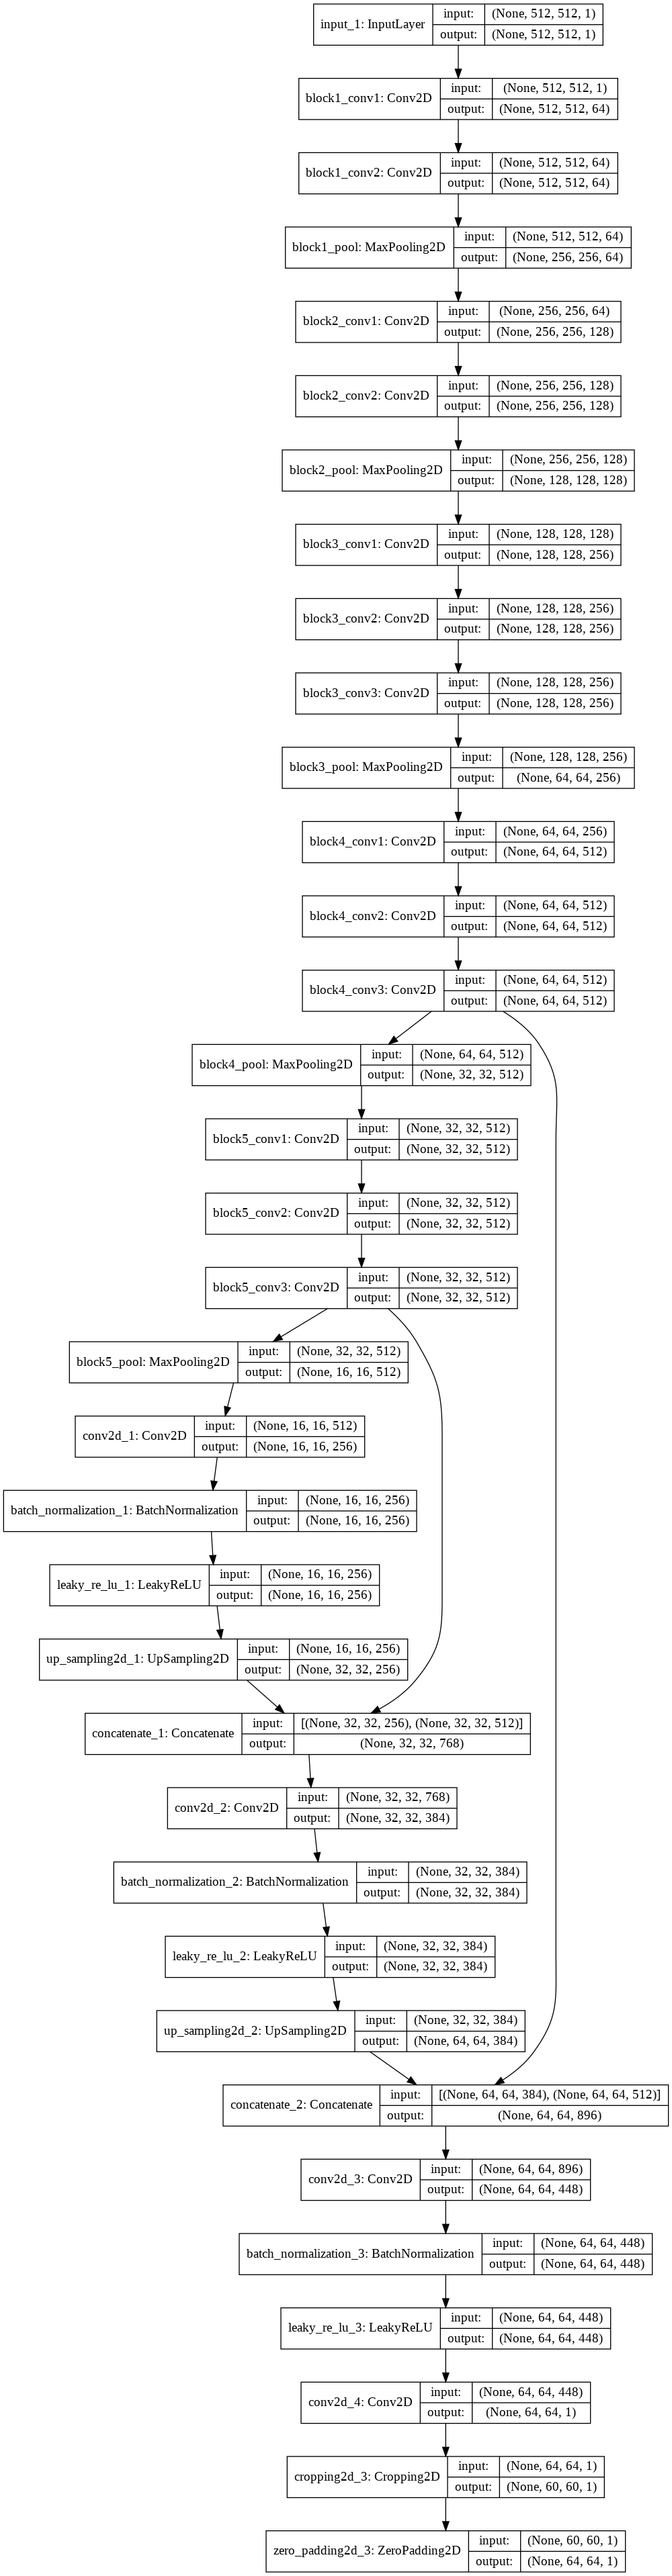

In [12]:
unet_model = unet_from_encoder(base_pretrained_model, 
                               (512//DOWNSCALE_OUTPUT, 
                                512//DOWNSCALE_OUTPUT, 1),
                              depth=2)
show_model(unet_model)

Build Input Generators


In [0]:
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

In [14]:
last_last_index=min(train_h5['image'].shape[0], 1000)
last_train_index = int(last_last_index*(1-TEST_SIZE))
print(last_train_index)
def make_gen(start_idx, last_idx, batch_size, seed=None):
    if seed is None:
        seed = np.random.choice(range(9999))
    flow_args = dict(**img_gen_args)
    img_gen = ImageDataGenerator(**img_gen_args)
    mask_args = flow_args.copy()
    mask_args.pop('preprocessing_function')
    mask_gen = ImageDataGenerator(**mask_args)
    while True:
        c_index = np.random.choice(range(start_idx, last_idx-batch_size))
        image_val = train_h5['image'][c_index:(c_index+batch_size)]
        image_val = np.concatenate([image_val, image_val, image_val], -1)
        mask_val = train_h5['mask'][c_index:(c_index+batch_size)][:, ::DOWNSCALE_OUTPUT, ::DOWNSCALE_OUTPUT]
        if USE_AUGMENTATION:
            for x, y in zip(img_gen.flow(image_val, seed = seed), 
                            mask_gen.flow(mask_val, seed = seed)):
                yield x, y
        else:
            yield image_val, mask_val 
train_gen = make_gen(0, last_train_index, BATCH_SIZE)
valid_gen = make_gen(last_train_index, train_h5['image'].shape[0],  BATCH_SIZE)

750


In [15]:
a, b = next(train_gen)
print(a.shape, b.shape)

(8, 512, 512, 3) (8, 64, 64, 1)


In [0]:
!pip3 install -q scikit-image

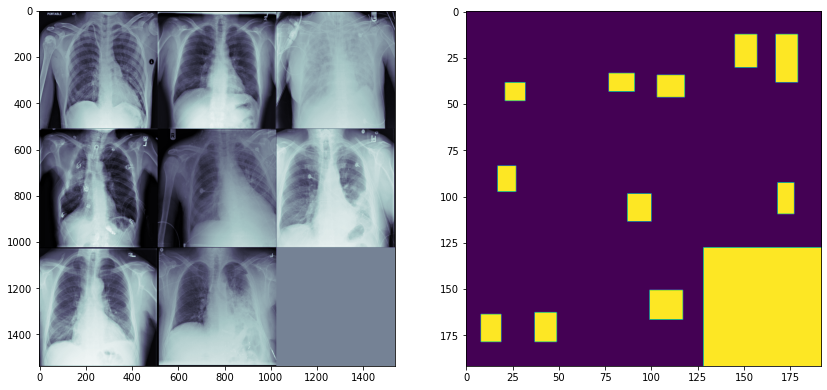

In [17]:
#from skimage.util.montage import montage2d
#from skimage.util import montage2d
#from skimage.util import montage2d as montage

from skimage.util import montage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
ax1.imshow(montage(a[:, :, :, 0]), cmap='bone')
ax2.imshow(montage(b[:, :, :, 0]))

In [18]:
print(tf.__version__)

1.15.0


In [19]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue 
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou 
    # teake the average over all images in batch
    metric /= batch_size
    return metric

def iou_score(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
for i_lay in unet_model.layers:
    if i_lay in base_pretrained_model.layers:
        if MODEL_WEIGHTS is not None:
            i_lay.trainable=False

unet_model.compile(optimizer=Adam(1e-3, decay = 1e-6), 
                   loss=dice_p_bce, 
                   metrics=[dice_coef, 
                            iou_score,
                            'binary_accuracy', 
                            true_positive_rate,])
loss_history = []
unet_model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
_____________

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('vgg_unet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [21]:
step_count = min(last_train_index//BATCH_SIZE, MAX_STEPS)
if USE_AUGMENTATION:
    loss_history += [unet_model.fit_generator(train_gen, 
                                             steps_per_epoch=step_count, 
                                             epochs=EPOCHS, 
                                             validation_data=valid_gen,
                                              validation_steps=TEST_SIZE/(1-TEST_SIZE)*step_count,
                                             callbacks=callbacks_list
                                           )]
else:
    train_img = train_h5['image'][:last_train_index]
    train_mask = train_h5['mask'][:last_train_index][:, ::DOWNSCALE_OUTPUT, ::DOWNSCALE_OUTPUT]
    valid_img = train_h5['image'][last_train_index:last_last_index]
    valid_mask = train_h5['mask'][last_train_index:last_last_index][:, ::DOWNSCALE_OUTPUT, ::DOWNSCALE_OUTPUT]
    loss_history += [unet_model.fit(train_img, train_mask,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, 
                                    validation_data=(valid_img, valid_mask),
                                    callbacks=callbacks_list
                                           )]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 750 samples, validate on 250 samples
Epoch 1/15
750/750 [==============================] - 55s 73ms/step - loss: -0.3644 - dice_coef: 0.3646 - iou_score: 0.0177 - binary_accuracy: 0.7760 - true_positive_rate: 0.7056 - val_loss: -0.3388 - val_dice_coef: 0.3405 - val_iou_score: 0.0039 - val_binary_accuracy: 0.8737 - val_true_positive_rate: 0.3366

Epoch 00001: val_loss improved from inf to -0.33878, saving model to vgg_unet_weights.best.hdf5
Epoch 2/15
750/750 [==============================] - 43s 57ms/step - loss: -0.4111 - dice_coef: 0.4113 - iou_score: 0.0220 - binary_accuracy: 0.8419 - true_positive_rate: 0.6323 - val_loss: -0.4216 - val_dice_coef: 0.4266 - val_iou_score: 0.0141 - val_binary_accuracy: 0.8775 - val_true_positive_rate: 0.4585

Epoch 00002: val_loss improved from -0.33878 to -0.42163, saving model to vgg_unet_weights.best.hdf5
Epoch 3/15
750/750 [====================

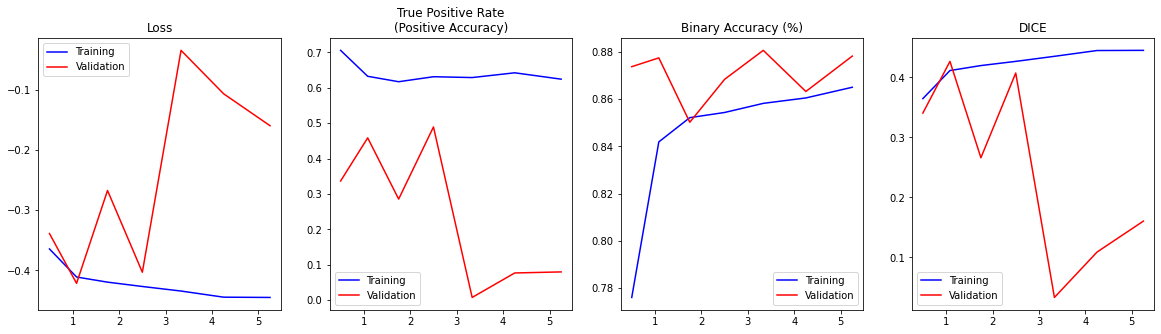

In [28]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [0]:
unet_model.load_weights(weight_path, by_name=True)

In [0]:
n_sample = 16
a, b = valid_img[:n_sample], valid_mask[:n_sample]

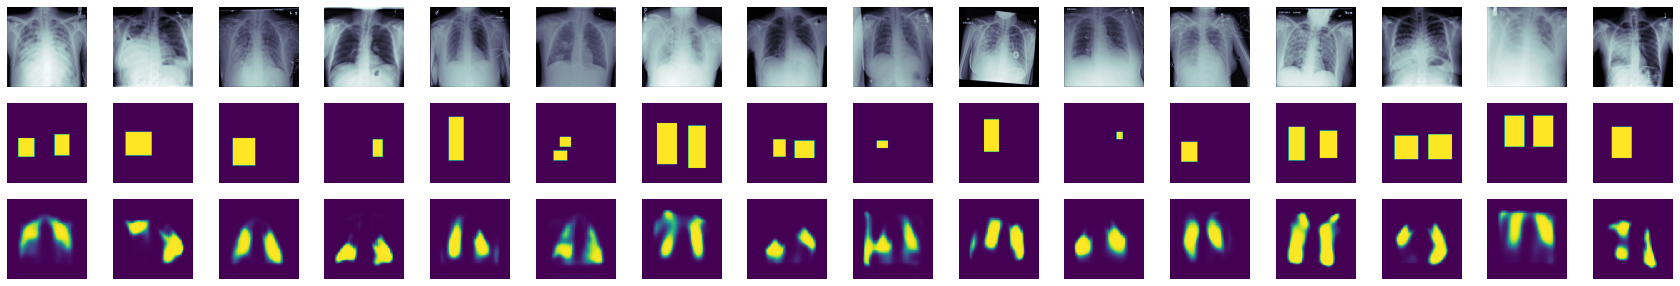

In [31]:
b_pred = unet_model.predict(a, batch_size=BATCH_SIZE)
fig, m_axs = plt.subplots(3, n_sample, figsize=(30, 5))
[n_ax.axis('off') for n_ax in m_axs.flatten()]
for x, y, y_pred, (ax1, ax2, ax3) in zip(a, b, b_pred, m_axs.T):    
    ax1.imshow(x[:, :, 0], cmap='bone')
    ax2.imshow(y[:, :, 0])
    ax3.imshow(y_pred[:, :, 0], vmin=0, vmax=1)
fig.savefig('prediction_pretrained.png')

In [32]:
out_scores = unet_model.evaluate(valid_img,
                              valid_mask,
                              batch_size=BATCH_SIZE
                             )

250/250 [==============================] - 5s 19ms/step


In [33]:
for k, v in zip(unet_model.metrics_names, out_scores):
    print('{}: {:.1%}'.format(k, v))

loss: -42.2%
dice_coef: 42.7%
iou_score: 1.4%
binary_accuracy: 87.7%
true_positive_rate: 45.9%
